In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy 

## Resistance precalculation
Precalculate resistance of variable resistor for equal distribution of points and limited voltage on string.

In [7]:
E       = 4      # Source voltage
R_n     = 13     # Approx resistance of string
R_e     = 10     # Resistance of etalon resistor
L       = 0.365  # String length
pi      = 3.14
kappa   = 0.025  # Approx thermal conductivity
ln_r0r1 = 5.3    # ln(r0/r1), r0 -- radius of outer tube, r1 -- string radius
dT      = 10     # Max temperature difference

err_ln_r0r1 = ((0.005/0.05)**2 + (0.1/10)**2)**0.5
err_ln_r0r1

0.10049875621120889

In [8]:
Q_n = 2 * pi * L / ln_r0r1 * kappa * dT
print("Q_n", Q_n)

Q_max = 4**2 * R_n / (R_n + R_e)**2
print("Q_max", Q_max)

a_max = Q_n / Q_max
print("a_max", a_max)

Q_n 0.10812264150943399
Q_max 0.3931947069943289
a_max 0.27498498730043547


In [9]:
print("a    | R_m    | U_n    | Q_n    ")
for i in range(1, 16):
    a = i / 50                                       # Q_n / Q_max
    R_m = (R_n + R_e) * (1 - a**0.5) / a**0.5
    I = E / (R_m + R_n + R_e)
    U_n = I * R_n
    Q_n = U_n**2 / R_n
    print("{:.2f} | {:6.2f} | {:6.4f} | {:6.4f}".format(a, R_m, U_n, Q_n))
    # print(R_m)

a    | R_m    | U_n    | Q_n    
0.02 | 139.63 | 0.3197 | 0.0079
0.04 |  92.00 | 0.4522 | 0.0157
0.06 |  70.90 | 0.5538 | 0.0236
0.08 |  58.32 | 0.6395 | 0.0315
0.10 |  49.73 | 0.7149 | 0.0393
0.12 |  43.40 | 0.7832 | 0.0472
0.14 |  38.47 | 0.8459 | 0.0550
0.16 |  34.50 | 0.9043 | 0.0629
0.18 |  31.21 | 0.9592 | 0.0708
0.20 |  28.43 | 1.0111 | 0.0786
0.22 |  26.04 | 1.0604 | 0.0865
0.24 |  23.95 | 1.1076 | 0.0944
0.26 |  22.11 | 1.1528 | 0.1022
0.28 |  20.47 | 1.1963 | 0.1101
0.30 |  18.99 | 1.2383 | 0.1180


## Data

In [10]:
d_U   = 0.000035 * 1.3 + 0.000005 * 10
eps_U = d_U / 0.23
print(d_U, eps_U)

9.549999999999999e-05 0.00041521739130434776


In [11]:
dR_e    = 0.0001*10
eps_R_e = 0.0001
print(dR_e, eps_R_e)

0.001 0.0001


In [12]:
eps_R = (eps_U**2 + eps_U**2 + eps_R_e**2)**0.5
print(eps_R)

eps_Q = eps_R

0.0005956601078494142


In [13]:
def read_data(columns):
    return pd.read_excel("223.ods", engine='odf', nrows=17, usecols=columns)

In [14]:
data = [
    read_data("F:I"),
    read_data("M:P"),
    read_data("T:W"),
    read_data("AA:AD"),
    read_data("AH:AK"),
    read_data("AO:AR"),
]

data[0].rename(columns = {'R':'R.0', 'Q':'Q.0', 'U_e':'U_e.0', 'U_str':'U_str.0'}, inplace = True)

T = np.array([
    22,
    30,
    40,
    50,
    60,
    70
])

data


[          R.0       Q.0    U_e.0  U_str.0
 0   14.545186  0.008171  0.23702  0.34475
 1   14.575093  0.016232  0.33372  0.48640
 2   14.608187  0.024223  0.40721  0.59486
 3   14.626133  0.032137  0.46875  0.68560
 4   14.659102  0.040034  0.52259  0.76607
 5   14.682081  0.047853  0.57090  0.83820
 6   14.711717  0.055647  0.61502  0.90480
 7   14.737003  0.063399  0.65590  0.96660
 8   14.765816  0.071097  0.69390  1.02460
 9   14.793751  0.078771  0.72970  1.07950
 10  14.820879  0.086384  0.76345  1.13150
 11  14.843249  0.094014  0.79585  1.18130
 12  14.876213  0.101600  0.82642  1.22940
 13  14.898341  0.109115  0.85580  1.27500,
           R.1       Q.1    U_e.1  U_str.1
 0   14.913319  0.008341  0.23650  0.35270
 1   14.937173  0.016530  0.33266  0.49690
 2   14.963021  0.024621  0.40564  0.60696
 3   14.996786  0.032664  0.46670  0.69990
 4   15.017787  0.040616  0.52005  0.78100
 5   15.044902  0.048521  0.56790  0.85440
 6   15.072032  0.056365  0.61153  0.92170
 7   15.09

In [15]:
# out = pd.DataFrame({'T' : T_clean, 'q' : q, 'U_F' : U_F})

def data_to_latex(out, i):
    names = [
        'R.'     + str(i),
        'Q.'     + str(i),
        'U_e.'   + str(i),
        'U_str.' + str(i)
    ]

    captions = {
        names[0] : r"$R, \text{Ом}$",
        names[1] : r"$Q, \text{Вт}$",
        names[2] : r"$U_{\text{эт}}, \text{В}$",
        names[3] : r"$U_{\text{нить}}, \text{В}$"
    }

    out_fmt = {
        captions[names[0]] : "{:.4f}",
        captions[names[1]] : "{:.4f}",
        captions[names[2]] : "{:.4f}",
        captions[names[3]] : "{:.4f}"
    }

    latex = out.rename(
                columns=(captions)
            ).style.hide(level=0, axis=0).format(out_fmt).to_latex(
                buf = 'UURQ_raw_' + str(i) + '.tex',
                # label = 'tab:linear',
                # caption = r'$T = ' + str(T[i]) + r' \; ^{\circ} C$',
                column_format="c" * 4,
                # position_float = 'centering',
                hrules=True,
                multicol_align = 'c',
            )


In [16]:
for i in range(0, len(data)):
    data_to_latex(data[i], i)

## R(Q)

In [17]:
colour = ["red", "blue", "green", "yellow", "purple", "orange", "white", "black"]

def lin_plot_RQ(x, y, label = None, i = 1):
    coeffs = np.polyfit(x, y, 1)
    equ = lambda x: coeffs[0] * x + coeffs[1]
    
    # plt.scatter(x, y, marker='.')
    x_space = np.linspace(0, max(x)*1.01, 100)
    plt.plot(x_space, equ(x_space), label = label, c = colour[i])
    plt.errorbar(x, y, yerr=y*eps_R, xerr=x*eps_Q, fmt='.', c = colour[i])
    

In [18]:
mnk_fmt = {
        '$\overline{x}$' : "{:.2e}",
        '$\sigma_x^2$'   : "{:.2e}",
        '$\overline{y}$' : "{:.2f}",
        '$\sigma_y^2$'   : "{:.2e}",
        '$r_{xy}$'       : "{:.2e}",
        '$a$'            : "{:.2f}",
        '$\Delta a$'     : "{:.2f}",
        '$b$'            : "{:.2f}",
        '$\Delta b$'     : "{:.2f}",
}

def least_sq(x, y):
    sx = (x**2).mean() - (x.mean())**2
    sy = (y**2).mean() - (y.mean())**2
    rxy = (y*x).mean() - (y.mean() * x.mean())
    a = rxy / sx
    da = (1/(len(x) - 2) * (sy/sx - a**2))**(0.5)
    b = y.mean() - a * x.mean()
    db = da*(sx + (x.mean())**2)**(1/2)
    dat = pd.DataFrame({
        '$\overline{x}$' : [x.mean()],
        '$\sigma_x^2$'   : [sx],
        '$\overline{y}$' : [y.mean()],
        '$\sigma_y^2$'   : [sy],
        '$r_{xy}$'       : [rxy],
        '$a$'            : [a],
        '$\Delta a$'     : [da],
        '$b$'            : [b],
        '$\Delta b$'     : [db],
    })
    return dat, [x.mean(), sx, y.mean(), sy, rxy, a, da, b, db]

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
5.92e-02 & 9.78e-04 & 14.72 & 1.19e-02 & 3.42e-03 & 3.49 & 0.02 & 14.52 & 0.00 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
5.99e-02 & 9.92e-04 & 15.08 & 1.11e-02 & 3.32e-03 & 3.35 & 0.03 & 14.88 & 0.00 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
6.06e-02 & 1.01e-03 & 15.53 & 1.10e-02 & 3.33e-03 & 3.31 & 0.01 & 15.33 & 0.00 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
6.14e-02 & 1.02e-03 & 15.98 & 1.07e-02 & 3.30e-03 & 3.23 & 0.01 & 15.78 & 0.00 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\si

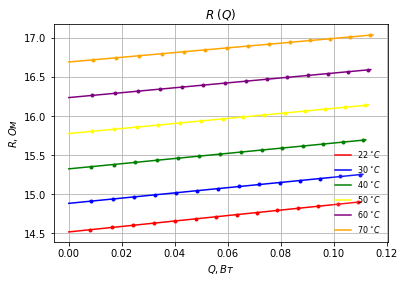

In [19]:
dR_dQ     = np.array([])      # dR/dQ
err_dR_dQ = np.array([])      # errors dR/dQ
R_0       = np.array([])      # R_0
err_R_0   = np.array([])      # errors R_0

for i in range(0, len(data)):
    x = data[i]['Q.' + str(i)]
    y = data[i]['R.' + str(i)]
    
    df, dat = least_sq(x, y)
    latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
    print(latex)
    
    dR_dQ     = np.append(dR_dQ, dat[5])
    err_dR_dQ = np.append(err_dR_dQ, dat[6])
    R_0       = np.append(R_0, dat[7])
    err_R_0   = np.append(err_R_0, dat[8])
    
    label = r"$" + str(T[i]) + " \; ^{\circ} C$"
    lin_plot_RQ(x, y, label, i)

plt.title("$R \; (Q)$")
plt.ylabel(r"$ R, Ом$")
plt.xlabel(r"$ Q, Вт$")
plt.grid(True)
plt.legend(fontsize = 8, framealpha = 0.1)

print("Coeffs")
print(dR_dQ)
print(err_dR_dQ)
print(R_0)
print(err_R_0)
plt.savefig("R_Q.pdf")

## R(T)

In [20]:
def lin_plot(x, y):
    coeffs = np.polyfit(x, y, 1)
    equ = lambda x: coeffs[0] * x + coeffs[1]
    
    # plt.scatter(x, y, marker='.')
    x_space = np.linspace(min(x)/1.01, max(x)*1.01, 100)
    plt.plot(x_space, equ(x_space))
    # plt.errorbar(x, y, yerr=0.1, xerr=0.001, fmt='.')
    

In [21]:
mnk_fmt = {
        '$\overline{x}$' : "{:.2e}",
        '$\sigma_x^2$'   : "{:.2e}",
        '$\overline{y}$' : "{:.2f}",
        '$\sigma_y^2$'   : "{:.2e}",
        '$r_{xy}$'       : "{:.2e}",
        '$a$'            : "{:.5f}",
        '$\Delta a$'     : "{:.5f}",
        '$b$'            : "{:.3f}",
        '$\Delta b$'     : "{:.3f}",
}

df, dat = least_sq(T, R_0)
dR_dT     = dat[5]    # dR/dT
err_dR_dT = dat[6]    # errors dR/dT

latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex(hrules = True)
print(latex)
df

\begin{tabular}{rrrrrrrrr}
\toprule
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
\midrule
4.53e+01 & 2.76e+02 & 15.57 & 5.65e-01 & 1.25e+01 & 0.04528 & 0.00014 & 13.520 & 0.007 \\
\bottomrule
\end{tabular}



,$\overline{x}$,$\sigma_x^2$,$\overline{y}$,$\sigma_y^2$,$r_{xy}$,$a$,$\Delta a$,$b$,$\Delta b$
0,45.333333,275.555556,15.572584,0.564989,12.477181,0.04528,0.000139,13.519886,0.006733


In [22]:
dat[5]/dat[7] # alpha = (dR/dT)/R

0.0033491473101917102

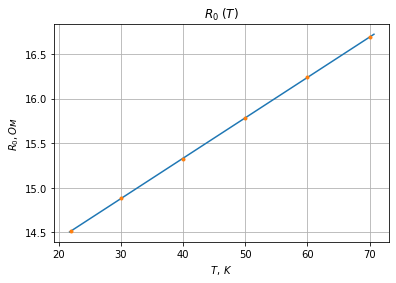

In [23]:
lin_plot(T, R_0)
plt.errorbar(T, R_0, xerr=0.1, yerr=err_R_0, fmt='.')

plt.title("$R_0 \; (T)$")
plt.ylabel(r"$R_0, Ом$")
plt.xlabel(r"$T, \; K$")
plt.grid(True)
# plt.legend()

plt.savefig("R_0_T.pdf")

## dQ/d(delta T)

In [24]:
dQ_dT     = dR_dT/dR_dQ
err_dQ_dT = dQ_dT * ((err_dR_dT/dR_dT)**2 + (err_dR_dQ/dR_dQ)**2)**(0.5)

kappa     = dQ_dT * ln_r0r1 / (2 * pi * L)
err_kappa = kappa * ((err_dQ_dT/dQ_dT)**2 + (err_ln_r0r1/ln_r0r1)**2)**0.5
print(err_kappa)

ln_kappa  = np.log(kappa)
ln_T      = np.log(T + 273)

[0.0006098  0.00065424 0.00061193 0.00062598 0.0006498  0.00068285]


In [28]:
mnk_fmt = {
        '$\overline{x}$' : "{:.2e}",
        '$\sigma_x^2$'   : "{:.2e}",
        '$\overline{y}$' : "{:.2f}",
        '$\sigma_y^2$'   : "{:.2e}",
        '$r_{xy}$'       : "{:.2e}",
        '$a$'            : "{:.2f}",
        '$\Delta a$'     : "{:.2f}",
        '$b$'            : "{:.2f}",
        '$\Delta b$'     : "{:.2f}",
}

df, dat = least_sq(ln_T, ln_kappa)

latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
print(latex)
df

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
5.76e+00 & 2.72e-03 & -3.44 & 2.19e-03 & 2.41e-03 & 0.88 & 0.08 & -8.53 & 0.43 \\
\end{tabular}



,$\overline{x}$,$\sigma_x^2$,$\overline{y}$,$\sigma_y^2$,$r_{xy}$,$a$,$\Delta a$,$b$,$\Delta b$
0,5.761739,0.002719,-3.436015,0.002191,0.002406,0.884869,0.075452,-8.534402,0.434755


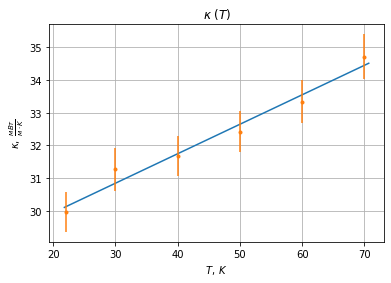

In [29]:
lin_plot(T, 1000 * kappa)
plt.errorbar(T, 1000 * kappa, xerr = 0.1, yerr = 1000 * err_kappa, fmt='.')

plt.title("$\kappa \; (T)$")
plt.ylabel(r"$\kappa, \; \frac{мВт}{м \cdot K}$")
plt.xlabel(r"$T, \; K$")
plt.grid(True)
# plt.legend()

plt.savefig("k_T.pdf")

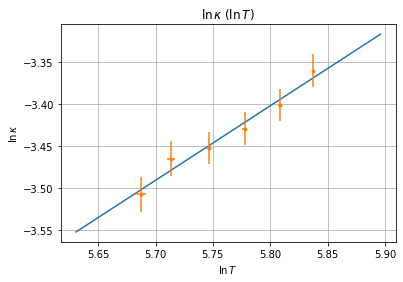

In [30]:
lin_plot(ln_T, ln_kappa)
plt.errorbar(ln_T, ln_kappa, xerr = 0.1/T, yerr = err_kappa/kappa, fmt='.')

plt.title("$\ln \kappa \; (\ln T)$")
plt.ylabel(r"$\ln \kappa$")
plt.xlabel(r"$\ln T$")
plt.grid(True)
# plt.legend()

plt.savefig("ln_k_ln_T.pdf")

## Print result table

In [31]:
out = pd.DataFrame({'T'       : T,
                    'dR_dQ'   : dR_dQ,        'err_dR_dQ' : err_dR_dQ,
                    'R_0'     : R_0,          'err_R_0'   : err_R_0,
                    'dQ_dT'   : 1000 * dQ_dT, 'err_dQ_dT' : 1000 * err_dQ_dT,
                    'kappa'   : 1000 * kappa, 'err_kappa' : 1000 * err_kappa
                   })

names = {
    'T'         : r"$T, ^{\circ}\text{C}$",
    
    'dR_dQ'     : r"$\frac{dR}{dQ}, \frac{\text{Ом}}{\text{Вт}}$",
    'err_dR_dQ' : r"$\frac{dR}{dQ}, \frac{\text{Ом}}{\text{Вт}}$",
    
    'R_0'       : r"$R_0, \text{Ом}$",
    'err_R_0'   : r"$\sigma(R_0), \text{Ом}$",
    
    'dQ_dT'     : r"$\frac{dQ}{dT}, \frac{\text{мВт}}{^{\circ}\text{С}}$",
    'err_dQ_dT' : r"$\sigma(\frac{dQ}{dT}), \frac{\text{мВт}}{^{\circ}\text{С}}$",
    
    'kappa'     : r"$\kappa, \; \frac{\text{мВт}}{\text{м} \cdot \text{K}}$",
    'err_kappa' : r"$\sigma(\kappa), \; \frac{\text{мВт}}{\text{м} \cdot \text{K}}$",
}

out_fmt = {
    names['T']         : "{:.1f}",
    
    names['dR_dQ']     : "{:.3f}",
    names['err_dR_dQ'] : "{:.3f}",
    
    names['R_0']       : "{:.4f}",
    names['err_R_0']   : "{:.4f}",
    
    names['dQ_dT']     : "{:.5f}",
    names['err_dQ_dT'] : "{:.5f}",
    
    names['kappa']     : "{:.1f}",
    names['err_kappa'] : "{:.1f}",
}

latex = out.rename(
            columns=(names)
        ).style.hide(level=0, axis=0).format(out_fmt).to_latex(
            buf = 'result.tex',
            # label = 'tab:linear',
            # caption = r'Зависимость $\overline{p}(T)$',
            column_format="c" * len(names),
            # position_float = 'centering',
            hrules=True,
            multicol_align = 'c',
            environment = ''
        )
